In [1]:
!pip install torch matplotlib numpy 

# MEMORY COMPARISON

 Running Memory Benchmark on: cuda
Training LSTM...
Final LSTM Loss: 4.6341
Training Transformer...
Final Transformer Loss: 3.9678


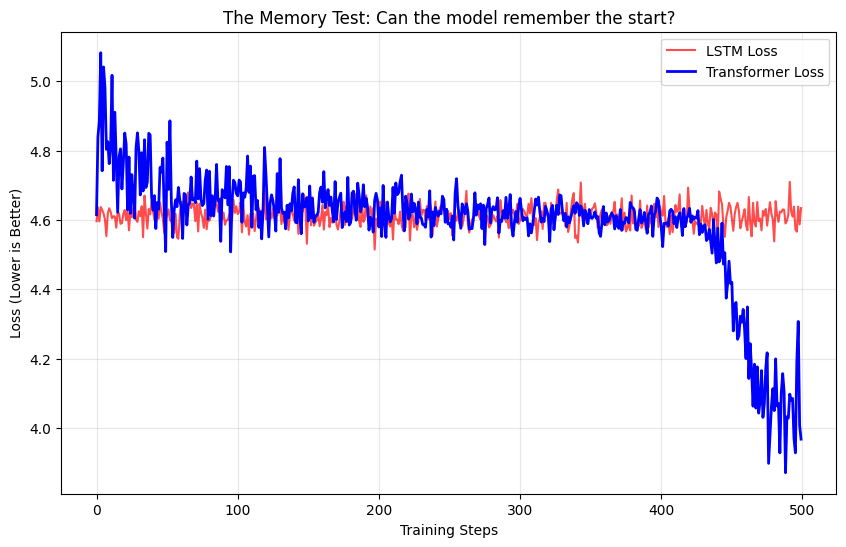

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt


SEQ_LEN = 100 
VOCAB_SIZE = 100
EMBED_DIM = 64
BATCH_SIZE = 32
STEPS = 500 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f" Running Memory Benchmark on: {device}")


def get_batch():
    # Generate random sequences
    data = torch.randint(1, VOCAB_SIZE, (BATCH_SIZE, SEQ_LEN)).to(device)
    # The target is to predict the FIRST token of the sequence at the END
    targets = data[:, 0] 
    return data, targets

# ---MODELs---
class SimpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.lstm = nn.LSTM(EMBED_DIM, EMBED_DIM, batch_first=True)
        self.fc = nn.Linear(EMBED_DIM, VOCAB_SIZE)
    
    def forward(self, x):
        x = self.embed(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1]) 

class SimpleTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.pe = nn.Parameter(torch.zeros(1, SEQ_LEN, EMBED_DIM)) 
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(EMBED_DIM, VOCAB_SIZE)
        
    def forward(self, x):
        x = self.embed(x) + self.pe
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)


def train(model, name):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    model.train()
    for i in range(STEPS):
        inputs, targets = get_batch()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses


print("Training LSTM...")
lstm_losses = train(SimpleLSTM().to(device), "LSTM")
print(f"Final LSTM Loss: {lstm_losses[-1]:.4f}")

print("Training Transformer...")
trans_losses = train(SimpleTransformer().to(device), "Transformer")
print(f"Final Transformer Loss: {trans_losses[-1]:.4f}")

# --- Graphs ---
plt.figure(figsize=(10, 6))
plt.plot(lstm_losses, label='LSTM Loss', color='red', alpha=0.7)
plt.plot(trans_losses, label='Transformer Loss', color='blue', linewidth=2)
plt.title("The Memory Test: Can the model remember the start?")
plt.xlabel("Training Steps")
plt.ylabel("Loss (Lower is Better)")
plt.legend()
plt.grid(True, alpha=0.3)


# TIME COMPARISON

 Running Speed Benchmark on: cpu
Seq Len 100 | LSTM: 0.0721s | Transformer: 0.0630s
Seq Len 500 | LSTM: 0.0068s | Transformer: 0.0827s
Seq Len 1000 | LSTM: 0.0115s | Transformer: 0.2398s
Seq Len 2000 | LSTM: 0.0212s | Transformer: 0.8487s
Seq Len 3000 | LSTM: 0.0265s | Transformer: 1.9769s


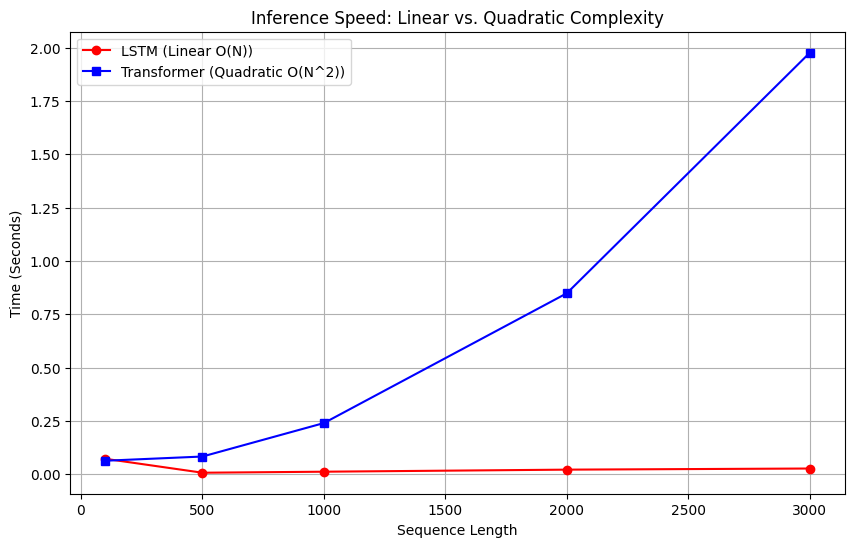

In [1]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

device = torch.device("cpu") 
SEQ_LENGTHS = [100, 500, 1000, 2000, 3000]
EMBED_DIM = 128

print(f" Running Speed Benchmark on: {device}")

# --- MODELS ---
class BenchLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=EMBED_DIM, hidden_size=EMBED_DIM, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

class BenchTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        enc = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, num_layers=2)

    def forward(self, x):
        return self.transformer(x)


lstm_times = []
trans_times = []

for N in SEQ_LENGTHS:
    
    x = torch.randn(1, N, EMBED_DIM).to(device)
    
    model_lstm = BenchLSTM().to(device)
    model_trans = BenchTransformer().to(device)
    
    # Measure LSTM
    start = time.time()
    with torch.no_grad():
        _ = model_lstm(x)
    lstm_times.append(time.time() - start)
    
    # Measure Transformer
    start = time.time()
    with torch.no_grad():
        _ = model_trans(x)
    trans_times.append(time.time() - start)
    
    print(f"Seq Len {N} | LSTM: {lstm_times[-1]:.4f}s | Transformer: {trans_times[-1]:.4f}s")

# --- Graphs ---
plt.figure(figsize=(10, 6))
plt.plot(SEQ_LENGTHS, lstm_times, marker='o', label='LSTM (Linear O(N))', color='red')
plt.plot(SEQ_LENGTHS, trans_times, marker='s', label='Transformer (Quadratic O(N^2))', color='blue')
plt.title("Inference Speed: Linear vs. Quadratic Complexity")
plt.xlabel("Sequence Length")
plt.ylabel("Time (Seconds)")
plt.legend()
plt.grid(True)
plt.show()